In [29]:
import pytorch_lightning as pl
import Utilities as ut
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from model import Hitting_prob_model
import math
from Langevin import Langevin_Dyn
from model import Hitting_prob_model
from pytorch_lightning.callbacks import ModelCheckpoint
import numpy as np
from Data_Handler import Data_Handler

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'


class Sine_activation(nn.Module):
    def __init__(self):
        '''
        Init method.
        '''
        super().__init__() # init the base class
    
    def forward(self, input):
        '''
        Forward pass of the function.
        '''
        return torch.sin(input)

final_state = torch.tensor([[-2.,0.],
                            [-2.,0.],
                            [-2.,0.],
                            [-2.,0.],
                            [-2.,0.],
                            [-2.,0.],
                            [-2.,0.],
                            [-2.,0.]], device = device)

mask = torch.tensor([[1.,0.],
                     [1.,0.],
                     [1.,0.],
                     [1.,0.],
                     [1.,0.],
                     [1.,0.],
                     [1.,0.],
                     [1.,0.]], device = device)

mlp_args = {
    'hidden_layers': 5, 
    'width': 256, 
    'input_dim': 17, 
    'activation': Sine_activation(), 
    'batch_norm': False,
    'dropout': False
    }

boundary_args = {
    'reference' : final_state,
    'tolerance' : .5,
    'slope' : 0.001,
    'mask' : mask,
    'keyword': 'Bump'
}

FBSDE_args = {
    'grad' : False,
    'alpha': 1,
    'beta': 0.1
}

normalization_dict = {
    'ph_space_means': torch.tensor([0,0], device = device),
    'time_mean': torch.tensor([0], device = device),
    'ph_space_stds': torch.tensor([5,15], device = device),
    'time_std': torch.tensor([1], device = device)
}

model_args = {
    'mlp_args': mlp_args, 
    'boundary_args': boundary_args, 
    'FBSDE_args':  FBSDE_args,
    'normalization_dict': normalization_dict
}

PATH = "./checkpoints_s/epoch=217-step=11335.ckpt"
model = Hitting_prob_model.load_from_checkpoint(
    PATH,
    map_location=torch.device('cpu'),
    **model_args
    )

# disable randomness, dropout, etc...

model.eval()
model.freeze()

100%|██████████| 21/21 [00:10<00:00,  2.02it/s]


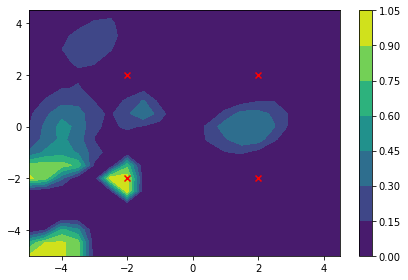

In [30]:
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

for t in tqdm(range(0,21)):
    probs = []
    for i in np.arange(-5,5, 0.5):
        tmp = []
        for j in np.arange(-5,5, 0.5):
            x = torch.tensor([[i,0.],
                            [j,0.],
                            [-2.,0.],
                            [-2.,0.],
                            [-2.,0.],
                            [-2.,0.],
                            [-2.,0.],
                            [-2.,0.]], device = device)
            x = x.view(1, x.size(0), -1)
            time = torch.tensor([t*5e-2]).view(1,-1)
            prob = model.model_application(x, time).item()
            #print(prob)
            tmp.append(prob)
        probs.append(tmp)

    x = np.arange(-5, 5, 0.5)
    y = np.arange(-5, 5, 0.5)
    plt.clf()
    plt.contourf(x, y, (probs))
    plt.colorbar()
    plt.scatter(-2,-2, c = 'r', marker='x')
    plt.scatter(2,2, c = 'r', marker='x')
    plt.scatter(-2,2, c = 'r', marker='x')
    plt.scatter(2,-2, c = 'r', marker='x')
    
    plt.tight_layout()
    plt.savefig('./plots/frame_{}.png'.format(t))
    

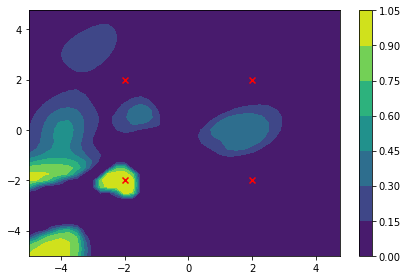

In [31]:
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

probs = []

for i in np.arange(-5,5, 0.25):
    tmp = []
    for j in np.arange(-5,5, 0.25):
        x = torch.tensor([[i,0.],
                        [j,0.],
                        [-2.,0.],
                        [-2.,0.],
                        [-2.,0.],
                        [-2.,0.],
                        [-2.,0.],
                        [-2.,0.]], device = device)
        x = x.view(1, x.size(0), -1)
        time = torch.tensor([1]).view(1,-1)
        prob = model.model_application(x, time).item()
        #print(prob)
        tmp.append(prob)
    probs.append(tmp)

x = np.arange(-5, 5, 0.25)
y = np.arange(-5, 5, 0.25)
plt.clf()
plt.contourf(x, y, np.log(probs))
plt.colorbar()
plt.scatter(-2,-2, c = 'r', marker='x')
plt.scatter(2,2, c = 'r', marker='x')
plt.scatter(-2,2, c = 'r', marker='x')
plt.scatter(2,-2, c = 'r', marker='x')

plt.tight_layout()

In [32]:
from Langevin import Langevin_Dyn
initial_state = torch.tensor([[2.,0.],
                              [2.,0.],
                              [2.,0.],
                              [2.,0.],
                              [2.,0.],
                              [2.,0.],
                              [2.,0.],
                              [2.,0.]], device = device)

def potential(x):
    c_0 = torch.tensor([-2,-2, -2,-2, -2,-2, -2,-2], device = device).view(1,8,-1).repeat(x.size(0), 1, 1)
    c_1 = torch.tensor([2,2, 2,2, 2,2, 2,2], device = device).view(1,8,-1).repeat(x.size(0), 1, 1)
    potential = (torch.exp(-((x/5).norm(dim = 2))**2)*((((x-c_0)**2).sum(dim = 2))*(((x-c_1)**2).sum(dim = 2)))).sum(dim = 1)
    potential.view(-1,1)
    return potential
    
args = {
    'Time_duration':1,
    'dt' : 1/1000,
    'temperature':torch.tensor([10.], device = device),
    'initial_state':initial_state.view(1, 8, -1),
    'masses':torch.tensor([1.], device = device),
    'drag':10.,
    'potential':potential,
    'potential_args':{},
    'device':device
}

dyn = Langevin_Dyn(**args)

In [33]:
from matplotlib import pyplot as plt

trajs, time, B = dyn.Dyn_run_driven(
    initial_state.view(1, 8, -1).repeat(1,1,1),
    committor_model=model.model_application
)
trajs = trajs.detach().numpy()

for k in range(0,1):
    for j in range(0,8):
        plt.plot(trajs[k,:,j,0])
plt.axhline(y=-2, color='r', linestyle='-')

 37%|███▋      | 372/1000 [00:08<00:15, 41.77it/s]

100%|██████████| 1000/1000 [00:02<00:00, 446.12it/s]


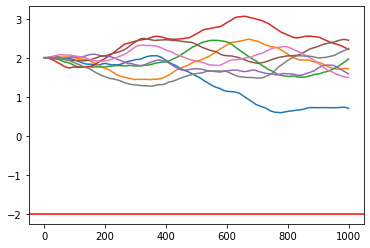

In [ ]:
from matplotlib import pyplot as plt

trajs, time, increments, B = dyn.Dyn_run(
    initial_state.view(1, 8, -1).repeat(1,1,1)
)
trajs = trajs.detach().numpy()

for k in range(0,1):
    for j in range(0,8):
        plt.plot(trajs[k,:,j,0])
plt.axhline(y=-2, color='r', linestyle='-')

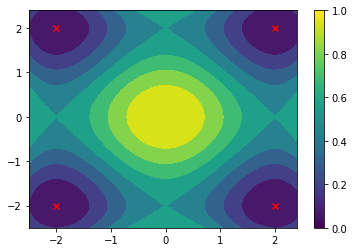

In [ ]:
def potential(x):
    c_0 = torch.tensor([-2,-2, -2,-2, -2,-2, -2,-2], device = device).view(1,8,-1).repeat(x.size(0), 1, 1)
    c_1 = torch.tensor([2,2, 2,2, 2,2, 2,2], device = device).view(1,8,-1).repeat(x.size(0), 1, 1)
    potential = (torch.exp(-((x/5).norm(dim = 2))**2)*((((x-c_0)**2).sum(dim = 2))*(((x-c_1)**2).sum(dim = 2)))).sum(dim = 1)
    potential.view(-1,1)
    return 10*potential

probs = []

grid = 2.5
step = 0.1

for i in np.arange(-grid, grid, step):
    tmp = []
    for j in np.arange(-grid, grid, step):
        x = torch.tensor([[i],
                        [j],
                        [-2.],
                        [-2.],
                        [-2.],
                        [-2.],
                        [-2.],
                        [-2.]], device = device)
        x = x.view(1, x.size(0), -1)
        prob = potential(x).item()
        tmp.append(prob)
    probs.append(tmp)
x = np.arange(-grid, grid, step)
y = np.arange(-grid, grid, step)
plt.clf()
plt.contourf(x, y, (probs))
plt.scatter(-2,-2, c = 'r', marker='x')
plt.scatter(2,2, c = 'r', marker='x')
plt.scatter(-2,2, c = 'r', marker='x')
plt.scatter(2,-2, c = 'r', marker='x')
plt.colorbar()

In [157]:
from Boundary_Conditions import Boundary_functions

ref = 0*torch.tensor([[2.,0.],
            [2.,0.],
            [2.,0.],
            [2.,0.],
            [2.,0.],
            [2.,0.],
            [2.,0.],
            [2.,0.]], device = device)

boundary_args = {
    'reference' : ref,
    'tolerance' : .5,
    'slope' : 0.001,
    'mask' : mask,
    'keyword': 'Indicator'
}

Func = Boundary_functions(**boundary_args)

In [204]:
a = torch.randn(10000, 8, 2)
c = Func.Function(a)

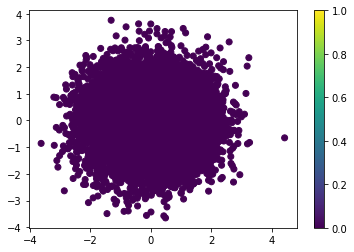

In [205]:
plt.scatter(a[:,0,0], a[:,1,0], c = c)
plt.colorbar()

In [16]:
a = torch.tensor(10)

In [22]:
type(a.get_device())

int